# Train Q on a LQR environment

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key = jax.random.split(key, 3)

# Box over states and actions
max_discrete_state = 5
n_discrete_states = 7
max_discrete_action = 5
n_discrete_actions = 7

# Q function
layers_dimension = [50]
random_weights_range = 1

# Q trainings
tolerance = 0.1
max_iterations = 10000
batch_size = 20
learning_rate = {"first": 0.001, "last": 0.0005, "duration": max_iterations}

# Visualisation
plot_freq = 200
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.10490131378173828s + -0.6472394466400146a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.21946656703948975s² + -0.19231724739074707a² + -0.11510777473449707sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer

n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

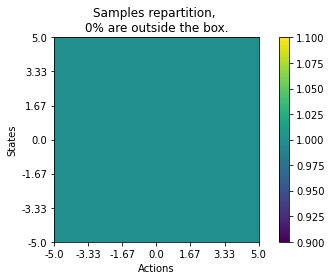

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

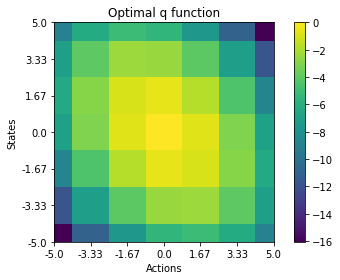

In [5]:
optimal_q = env.optimal_Q_mesh(discrete_states, discrete_actions)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network and its dataloader

In [6]:
from pbo.networks.q import FullyConnectedQ
from pbo.sample_collection.dataloader import SampleDataLoader


q = FullyConnectedQ(
    layers_dimension=layers_dimension,
    network_key=q_network_key,
    random_weights_range=random_weights_range,
    random_weights_key=random_weights_key,
    action_range_on_max=0,
    n_actions_on_max=0,
)

replay_buffer.cast_to_jax_array()
data_loader = SampleDataLoader(replay_buffer, batch_size, shuffle_key)

## Define the optimizer

In [7]:
import jax
import optax


learning_rate_schedule = optax.linear_schedule(learning_rate["first"], learning_rate["last"], learning_rate["duration"])
optimizer = optax.adam(learning_rate_schedule)
optimizer_state = optimizer.init(q.params)


@jax.jit
def learn_on_batch(
    params: dict, optimizer_state: tuple, batch: jnp.ndarray
) -> tuple:
    batch_targets = env.optimal_Q_values(batch["state"], batch["action"])

    loss, grad_loss = q.l2_loss_and_grad(params, batch["state"], batch["action"], batch_targets)
    updates, optimizer_state = optimizer.update(grad_loss, optimizer_state)
    params = optax.apply_updates(params, updates)

    return params, optimizer_state, loss

## Train Q 
Objective: See if the representation power of the network of Q is powerful enough to represent the optimal Q

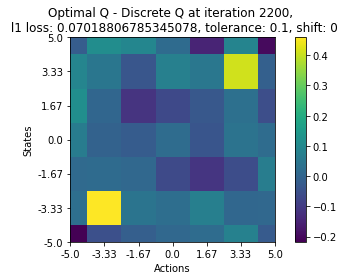

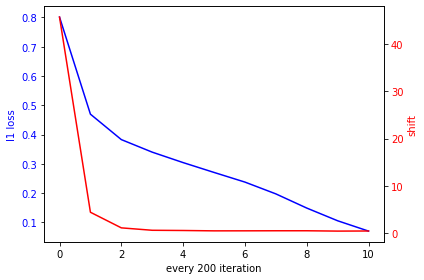

In [8]:
import jax.numpy as jnp

from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
former_discrete_q = q.discretize(q.to_weights(q.params).reshape((1, -1)), discrete_states, discrete_actions)[0]
l1_losses = []
shifts = []

iteration = 0
l1_loss = float("inf")

while l1_loss > tolerance and iteration < max_iterations:
    cumulative_l2_loss = 0

    data_loader.shuffle()
    for batch in data_loader:
        q.params, optimizer_state, loss = learn_on_batch(q.params, optimizer_state, batch)
        cumulative_l2_loss += loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        discrete_q = q.discretize(q.to_weights(q.params).reshape((1, -1)), discrete_states, discrete_actions)[0]

        l1_loss = jnp.abs(optimal_q - discrete_q).mean()
        shift = jnp.linalg.norm(discrete_q - former_discrete_q)
        
        q_visu_mesh.set_values(optimal_q - discrete_q)
        q_visu_mesh.show(f"Optimal Q - Discrete Q at iteration {iteration}, \n l1 loss: {l1_loss}, tolerance: {tolerance}, shift: {int(shift)}")
        
        l1_losses.append(l1_loss)
        shifts.append(shift)
        former_discrete_q = discrete_q

shared_axis_plot(l1_losses, shifts, f"every {plot_freq} iteration", "l1 loss", "shift")

## Maximizing Q over actions

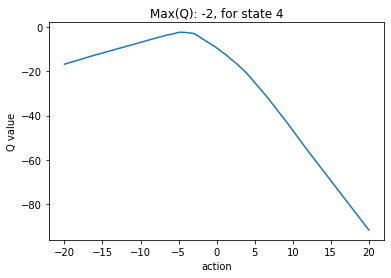

In [9]:
import matplotlib.pyplot as plt


random_q_params = q.to_params(q.random_weights())
# random_q_params = q.to_params(q.random_init_weights())
random_state = jnp.array([np.random.uniform(-max_discrete_state, max_discrete_state)])

discrete_actions_on_max = jnp.linspace(
    -20, 20, num=10000
).reshape((-1, 1))

q_values = q.network.apply(
    random_q_params, random_state.repeat(len(discrete_actions_on_max)).reshape((-1, 1)), discrete_actions_on_max
)

plt.plot(discrete_actions_on_max, q_values)
plt.xlabel("action")
plt.ylabel("Q value")
_ = plt.title(f"Max(Q): {int(q_values.max())}, for state {int(random_state[0])}")

- Q is not spiky so discretizing the action space should work
- Taking random init weights gives smaller maximums than taking random weights